In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from matplotlib.ticker import FormatStrFormatter
from catboost import CatBoostClassifier

from detectshift.utils import *
from detectshift.exp_utils import *
from detectshift.tests import *
from detectshift.cd_models import *

%config InlineBackend.figure_format = 'retina'

####### Fixing Seed #######
random_seed=42
np.random.seed(random_seed)
###########################

## Setting datasets up

check if ids and names are consistent in time

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:

data = {}
X, y = {}, {}

important_features = ['zqtcontratoativoa30d',
 'zqtfatura60dpgfullprz',
 'zqtcontratoativoa90d',
 'zpont_vl_ct',
 'zpont_qt_ct']

target_name = ['SConcEver30dP3_100']

In [4]:
%%time
for i in range(10):
    data_path = f'../drift/data/dataset_t{i}_important.parquet'
    
    print('load ',data_path )
    all_data = pd.read_parquet(data_path)
    
    data[i] = all_data[important_features+target_name]
    
    del all_data
    

load  ../drift/data/dataset_t0_important.parquet
load  ../drift/data/dataset_t1_important.parquet
load  ../drift/data/dataset_t2_important.parquet
load  ../drift/data/dataset_t3_important.parquet
load  ../drift/data/dataset_t4_important.parquet
load  ../drift/data/dataset_t5_important.parquet
load  ../drift/data/dataset_t6_important.parquet
load  ../drift/data/dataset_t7_important.parquet
load  ../drift/data/dataset_t8_important.parquet
load  ../drift/data/dataset_t9_important.parquet
CPU times: user 16.2 s, sys: 3.81 s, total: 20.1 s
Wall time: 8.58 s


In [5]:
test=.2
Nsample = 2*10**4

X_train, y_train, X_test, y_test = {},{},{},{}

for t in range(10):
    print('t = ', t)
    data_sample = data[t].sample(Nsample, random_state=1)
    X , y = data_sample[important_features], data_sample[target_name]
    X_train[t], X_test[t], y_train[t], y_test[t] = train_test_split(X, y, test_size=test, random_state=random_seed)

t =  0
t =  1
t =  2
t =  3
t =  4
t =  5
t =  6
t =  7
t =  8
t =  9


In [7]:
pvals=[]
kls=[]

for t in tqdm(range(10)):
    print('t = ', t)
    
    ### Setting-up data
    Xs_train, ys_train, Xt_train, yt_train = (pd.DataFrame(X_train[0])
                                            , pd.DataFrame(y_train[0])
                                            , pd.DataFrame(X_train[t])
                                            , pd.DataFrame(y_train[t]))

    Xs_test, ys_test, Xt_test, yt_test = (pd.DataFrame(X_test[0])
                                        , pd.DataFrame(y_test[0])
                                        , pd.DataFrame(X_test[t])
                                        , pd.DataFrame(y_test[t]))
            
    
    ys_train = ys_train.astype('int32')
    yt_train = yt_train.astype('int32')
    ys_test  = ys_test.astype('int32')
    yt_test  = yt_test.astype('int32')
    
    Zs_train = pd.concat([Xs_train, ys_train], axis=1) 
    Zt_train = pd.concat([Xt_train, yt_train], axis=1) 
    Zs_test  = pd.concat([Xs_test, ys_test], axis=1) 
    Zt_test  = pd.concat([Xt_test, yt_test], axis=1) 
    
    ### Training models
    print('total shift')
    totshift_model = KL(boost=True)
    totshift_model.fit(Zs_train, Zt_train)

    print('cov shift')  
    covshift_model = KL(boost=True)
    covshift_model.fit(Xs_train, Xt_train)

    print('cond shift')  
    cd_model = cde_class(boost=True)
    cd_model.fit(np.vstack((Xs_train,Xt_train)), np.vstack((ys_train,yt_train)))
    
    ### Getting test statistics and p-vals
    B=100
    
    print('bootstrap')
    out = ShiftDiagnostics(Xs_test, ys_test, Xt_test, yt_test,
                           totshift_model=totshift_model, covshift_model=covshift_model, labshift_model=None,
                           cd_model=cd_model, B=B, verbose=False)
    
    ### Output
    pvals.append([t, out['lab']['pval'], out['cov']['pval'], out['conc1']['pval'], out['conc2']['pval'], out['tot']['pval']])
    kls.append([t, out['lab']['kl'], out['cov']['kl'], out['conc1']['kl'], out['conc2']['kl'], out['tot']['kl']])


  0%|          | 0/10 [00:00<?, ?it/s]

t =  0
total shift
cov shift
cond shift
bootstrap


 10%|█         | 1/10 [00:19<02:51, 19.03s/it]

t =  1
total shift
cov shift
cond shift
bootstrap


 20%|██        | 2/10 [00:33<02:12, 16.55s/it]

t =  2
total shift
cov shift
cond shift
bootstrap


 30%|███       | 3/10 [00:48<01:48, 15.49s/it]

t =  3
total shift
cov shift
cond shift
bootstrap


 40%|████      | 4/10 [01:01<01:28, 14.72s/it]

t =  4
total shift
cov shift
cond shift
bootstrap


 50%|█████     | 5/10 [01:16<01:14, 14.88s/it]

t =  5
total shift
cov shift
cond shift
bootstrap


 60%|██████    | 6/10 [01:31<00:58, 14.68s/it]

t =  6
total shift
cov shift
cond shift
bootstrap


 70%|███████   | 7/10 [01:44<00:43, 14.42s/it]

t =  7
total shift
cov shift
cond shift
bootstrap


 80%|████████  | 8/10 [01:58<00:28, 14.16s/it]

t =  8
total shift
cov shift
cond shift
bootstrap


 90%|█████████ | 9/10 [02:12<00:14, 14.18s/it]

t =  9
total shift
cov shift
cond shift
bootstrap


100%|██████████| 10/10 [02:27<00:00, 14.74s/it]


In [8]:
kls=np.array(kls)
pvals=np.array(pvals)

In [9]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.25   # the amount of width reserved for blank space between subplots
hspace = 0.35   # the amount of height reserved for white space between subplots

In [32]:
def exp_plots(theta, series, ylab, grid):
    
    names=['$\mathcal{P}_{Y}$','$\mathcal{P}_{X}$',
           '$\mathcal{P}_{X|Y}$','$\mathcal{P}_{Y|X}$',
           '$\mathcal{P}_{X,Y}$']
    colors=['#2F58EB', '#773BEB', '#12B8EB', '#EB9846', '#6D8AF1','#808080']
    
    plt.plot(theta, series[:,1], color=colors[4], marker="^", lw=2, label=names[0], alpha=.7, markersize=6)
    plt.plot(theta, series[:,2], color=colors[3], marker="v", lw=2, label=names[1], alpha=.7, markersize=6)
    plt.plot(theta, series[:,3], color=colors[2], marker="D", lw=2, label=names[2], alpha=.7, markersize=6)
    plt.plot(theta, series[:,4], color=colors[1], marker="s", lw=2, label=names[3], alpha=.7, markersize=6)
    plt.plot(theta, series[:,5], color=colors[0], marker="o", lw=2, label=names[4], alpha=.7, markersize=6)

    plt.legend(bbox_to_anchor=(.05, .975), loc='upper left', 
                   ncol = 3, prop={'size': 11}, borderaxespad=.0, frameon=False)
        
    plt.grid(alpha=.2, axis=grid)
    plt.axhline(y=0, color='k', linestyle='-', lw=1, alpha=.25)
    plt.ylabel(ylab, size=13)
    plt.xlabel("", size=13)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
    plt.locator_params(axis="y", nbins=4)

In [33]:
years_lab= ['Aug19','Sep19','Oct19','Nov19','Dec19',
         'Jan20','Feb20','Mar20','Apr20','May20']

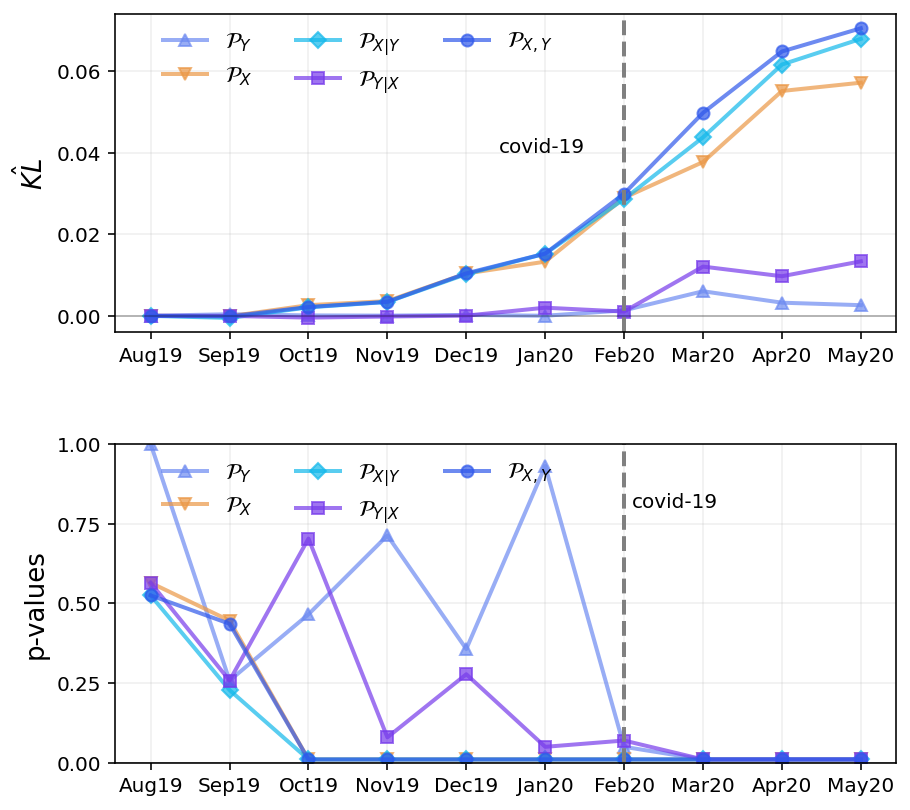

In [34]:
plt.figure(figsize=(7,6.5))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

ax1 = plt.subplot(2, 1, 1)
exp_plots(years_lab, kls, ylab="$\hat{KL}$", grid='both')

covid_date = 6
ax1.axvline(x=covid_date ,ls='--', color='grey', lw=2)
ax1.text(x=covid_date-0.5,y=0.04,s='covid-19',ha='right')

ax2 = plt.subplot(2, 1, 2)
exp_plots(years_lab, pvals, ylab="p-values", grid='both')
plt.ylim(0,1)

ax2.axvline(x=covid_date ,ls='--', color='grey', lw=2)
ax2.text(x=covid_date+0.1,y=0.8,s='covid-19',ha='left')

plt.savefig('plots/credit_new.png', bbox_inches='tight', dpi=300, transparent=True)

